In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        train_y[i * n + j] = pow(-1, int(2 * i / n + int( 2 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(10, [(0, 1), (0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [12]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    n = 100
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
        print rand_var.mean().ge(0.5).float().mul(2).sub(1).view(n, n)
        color = []
        for i in range(len(pred_labels)):
            if pred_labels[i] == 1:
                color.append('b')
            else:
                color.append('r')
        ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color)
        ax.set_ylim([-0.5, 1.5])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

In [6]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()

/Users/ruihanwu/playground/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/20 - Loss: 318447.438   log_lengthscale: 0.000
Iter 2/20 - Loss: 61300.785   log_lengthscale: -0.100
Iter 3/20 - Loss: 34305.590   log_lengthscale: -0.183
Iter 4/20 - Loss: 38543.992   log_lengthscale: -0.262
Iter 5/20 - Loss: 25560.086   log_lengthscale: -0.345
Iter 6/20 - Loss: 23333.410   log_lengthscale: -0.431
Iter 7/20 - Loss: 19702.008   log_lengthscale: -0.514
Iter 8/20 - Loss: 21653.717   log_lengthscale: -0.601
Iter 9/20 - Loss: 19578.395   log_lengthscale: -0.685
Iter 10/20 - Loss: 23175.676   log_lengthscale: -0.768
Iter 11/20 - Loss: 12649.883   log_lengthscale: -0.850
Iter 12/20 - Loss: 19839.990   log_lengthscale: -0.932
Iter 13/20 - Loss: 19825.902   log_lengthscale: -1.016
Iter 14/20 - Loss: 14038.142   log_lengthscale: -1.100
Iter 15/20 - Loss: 13634.162   log_lengthscale: -1.186
Iter 16/20 - Loss: 11585.962   log_lengthscale: -1.269
Iter 17/20 - Loss: 13304.151   log_lengthscale: -1.349
Iter 18/20 - Loss: 15788.870   log_lengthscale: -1.425
Iter 19/20 - Loss: 

Iter 153/20 - Loss: 661.100   log_lengthscale: -3.358
Iter 154/20 - Loss: 689.161   log_lengthscale: -3.360
Iter 155/20 - Loss: 595.920   log_lengthscale: -3.362
Iter 156/20 - Loss: 513.628   log_lengthscale: -3.364
Iter 157/20 - Loss: 759.101   log_lengthscale: -3.366
Iter 158/20 - Loss: 714.257   log_lengthscale: -3.368
Iter 159/20 - Loss: 683.427   log_lengthscale: -3.370
Iter 160/20 - Loss: 594.307   log_lengthscale: -3.371
Iter 161/20 - Loss: 678.987   log_lengthscale: -3.373
Iter 162/20 - Loss: 580.880   log_lengthscale: -3.375
Iter 163/20 - Loss: 630.834   log_lengthscale: -3.377
Iter 164/20 - Loss: 721.746   log_lengthscale: -3.378
Iter 165/20 - Loss: 600.379   log_lengthscale: -3.380
Iter 166/20 - Loss: 632.869   log_lengthscale: -3.381
Iter 167/20 - Loss: 625.787   log_lengthscale: -3.383
Iter 168/20 - Loss: 622.265   log_lengthscale: -3.384
Iter 169/20 - Loss: 586.854   log_lengthscale: -3.385
Iter 170/20 - Loss: 526.534   log_lengthscale: -3.387
Iter 171/20 - Loss: 641.306 

_VariationalGPPosterior (
  (likelihood): BernoulliLikelihood (
  )
  (prior_model): GPClassificationModel (
    (likelihood): BernoulliLikelihood (
    )
    (mean_module): ConstantMean (
    )
    (covar_module): RBFKernel (
    )
    (grid_covar_module): GridInterpolationKernel (
      (base_kernel_module): RBFKernel (
      )
    )
  )
)

Variable containing:
    1     1     1  ...     -1    -1    -1
    1     1     1  ...     -1    -1    -1
    1     1     1  ...     -1    -1    -1
       ...          ⋱          ...       
   -1    -1    -1  ...      1     1     1
   -1    -1    -1  ...      1     1     1
   -1    -1    -1  ...      1     1     1
[torch.FloatTensor of size 100x100]



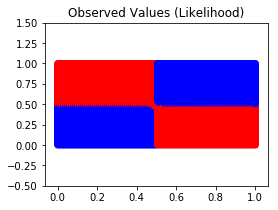

In [13]:
f = plot_model_and_predictions(posterior_model)